In [1]:
import pandas as pd
import cupy as cp
import cubewalkers as cw
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from matplotlib.patches import Rectangle
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
plt.rcParams.update({'font.size':20})

In [2]:
QCF = pd.read_csv('data/quasicoherence_fuzzy_withsource.csv')
QC = pd.read_csv('data/quasicoherence_nonfuzzy_withsource.csv')
QCFNS = pd.read_csv('data/quasicoherence_fuzzy_sourceless.csv')
QCNS = pd.read_csv('data/quasicoherence_nonfuzzy_sourceless.csv')
FHD = pd.read_csv('data/final_hamming_distance_withsource.csv')
FHDNS = pd.read_csv('data/final_hamming_distance_sourceless.csv')
DC = pd.read_csv('data/derrida_coefficients.csv')
QC = QC.merge(QCF)
QC = QC.merge(QCNS)
QC = QC.merge(QCFNS)
QC = QC.merge(FHD)
QC = QC.merge(FHDNS)
QC = QC.merge(DC)
QC.columns = ['name', 
              'SQC', 'AQC', 
              'SFQC', 'AFQC', 
              'SQCNS', 'AQCNS', 
              'SFQCNS', 'AFQCNS',
              'SFHD', 'AFHD', 
              'SFHDNS', 'AFHDNS',
              'SDC', 'ADC', 
              'SDCNS', 'ADCNS']



N = []
NS = []
for name in sorted(QC['name']):
    with open(f'models/cell_collective/{name}.txt') as f:
        nt = 0
        ns = 0
        for row in f:
            nt += 1
            if row.split(',')[0].strip() == row.split(',')[1].strip():
                ns += 1
        N.append(nt)
        NS.append(ns)

NDF = pd.DataFrame({
    'name': sorted(QC['name']),
    'N': N,
    'NS': NS,
})

QC=QC.merge(NDF)

# Fragility = 
# long-term difference in node avg. values after initial 1-node perturbation
QC['AF'] = (1-QC['AFQC'])*(QC['N'])
QC['SF'] = (1-QC['SFQC'])*(QC['N'])
QC['AFNS'] = (1-QC['AFQCNS'])*(QC['N']-QC['NS'])
QC['SFNS'] = (1-QC['SFQCNS'])*(QC['N']-QC['NS'])

QC.sort_values(by=['name'])

,name,SQC,AQC,SFQC,AFQC,SQCNS,AQCNS,SFQCNS,AFQCNS,SFHD,AFHD,SFHDNS,AFHDNS,SDC,ADC,SDCNS,ADCNS,N,NS,AF,SF,AFNS,SFNS
0,Apoptosis Network,0.903063,0.911766,0.975734,0.976564,0.949374,0.958523,0.989265,0.991469,1.433632,1.119603,0.811839,0.461110,1.00488,1.037920,0.928257,0.957248,41,2,0.960876,0.994906,0.332709,0.418665
1,Arabidopsis thaliana Cell Cycle,1.000000,1.000000,0.999986,1.000000,1.000000,1.000000,0.999986,1.000000,1.732337,0.000000,1.732337,0.000000,1.27225,1.215076,1.271043,1.227097,14,0,0.000000,0.000196,0.000000,0.000196
2,Aurora Kinase A in Neuroblastoma,0.761200,0.778609,0.943288,0.941871,0.921453,0.942526,0.958815,0.953696,1.825235,1.337004,1.357291,0.879826,1.04819,1.063182,0.991720,0.999190,23,4,1.336967,1.304376,0.879776,0.782515
3,B bronchiseptica and T retortaeformis coinfection,0.911064,0.925494,0.991302,0.988368,0.928585,0.943292,0.992855,0.990268,0.464348,0.616483,0.374940,0.506085,1.00127,0.996849,0.966009,0.967529,53,1,0.616496,0.460994,0.506064,0.371540
4,B cell differentiation,0.736564,0.739491,0.957846,0.955954,0.953200,0.956988,0.986464,0.987694,0.927391,0.969018,0.230118,0.209200,0.99674,1.019382,0.704322,0.747895,22,5,0.969012,0.927388,0.209202,0.230112
5,BT474 Breast Cell Line Long-term ErbB Network,0.622832,0.605360,0.973295,0.971707,0.819516,0.796526,0.985526,0.983151,0.667616,0.707328,0.275011,0.320126,0.94772,0.922200,0.803044,0.794584,25,6,0.707325,0.667625,0.320131,0.275006
6,BT474 Breast Cell Line Short-term ErbB Network,0.641475,0.602025,0.964380,0.958502,0.933055,0.875673,0.989379,0.982869,0.569925,0.663975,0.116836,0.188436,0.76086,0.826380,0.374177,0.553145,16,5,0.663968,0.569920,0.188441,0.116831
7,Bordetella bronchiseptica,0.970642,0.966521,0.993765,0.998550,0.970642,0.966521,0.993765,0.998550,0.206618,0.047855,0.206618,0.047855,1.01878,0.990579,1.013961,0.999820,33,0,0.047850,0.205755,0.047850,0.205755
8,Bortezomib Responses in U266 Human Myeloma Cells,0.924615,0.920203,0.991630,0.988959,0.999181,0.994413,0.999562,0.996934,0.560776,0.739737,0.027134,0.190103,0.97716,1.008713,0.898823,0.935004,67,5,0.739747,0.560790,0.190092,0.027156
9,Budding Yeast Cell Cycle,0.721320,0.781560,0.952011,0.953503,0.901650,0.976950,0.986100,0.992657,1.060696,0.929999,0.332186,0.117573,1.01413,1.019960,0.825870,0.865000,20,4,0.929940,0.959780,0.117488,0.222400


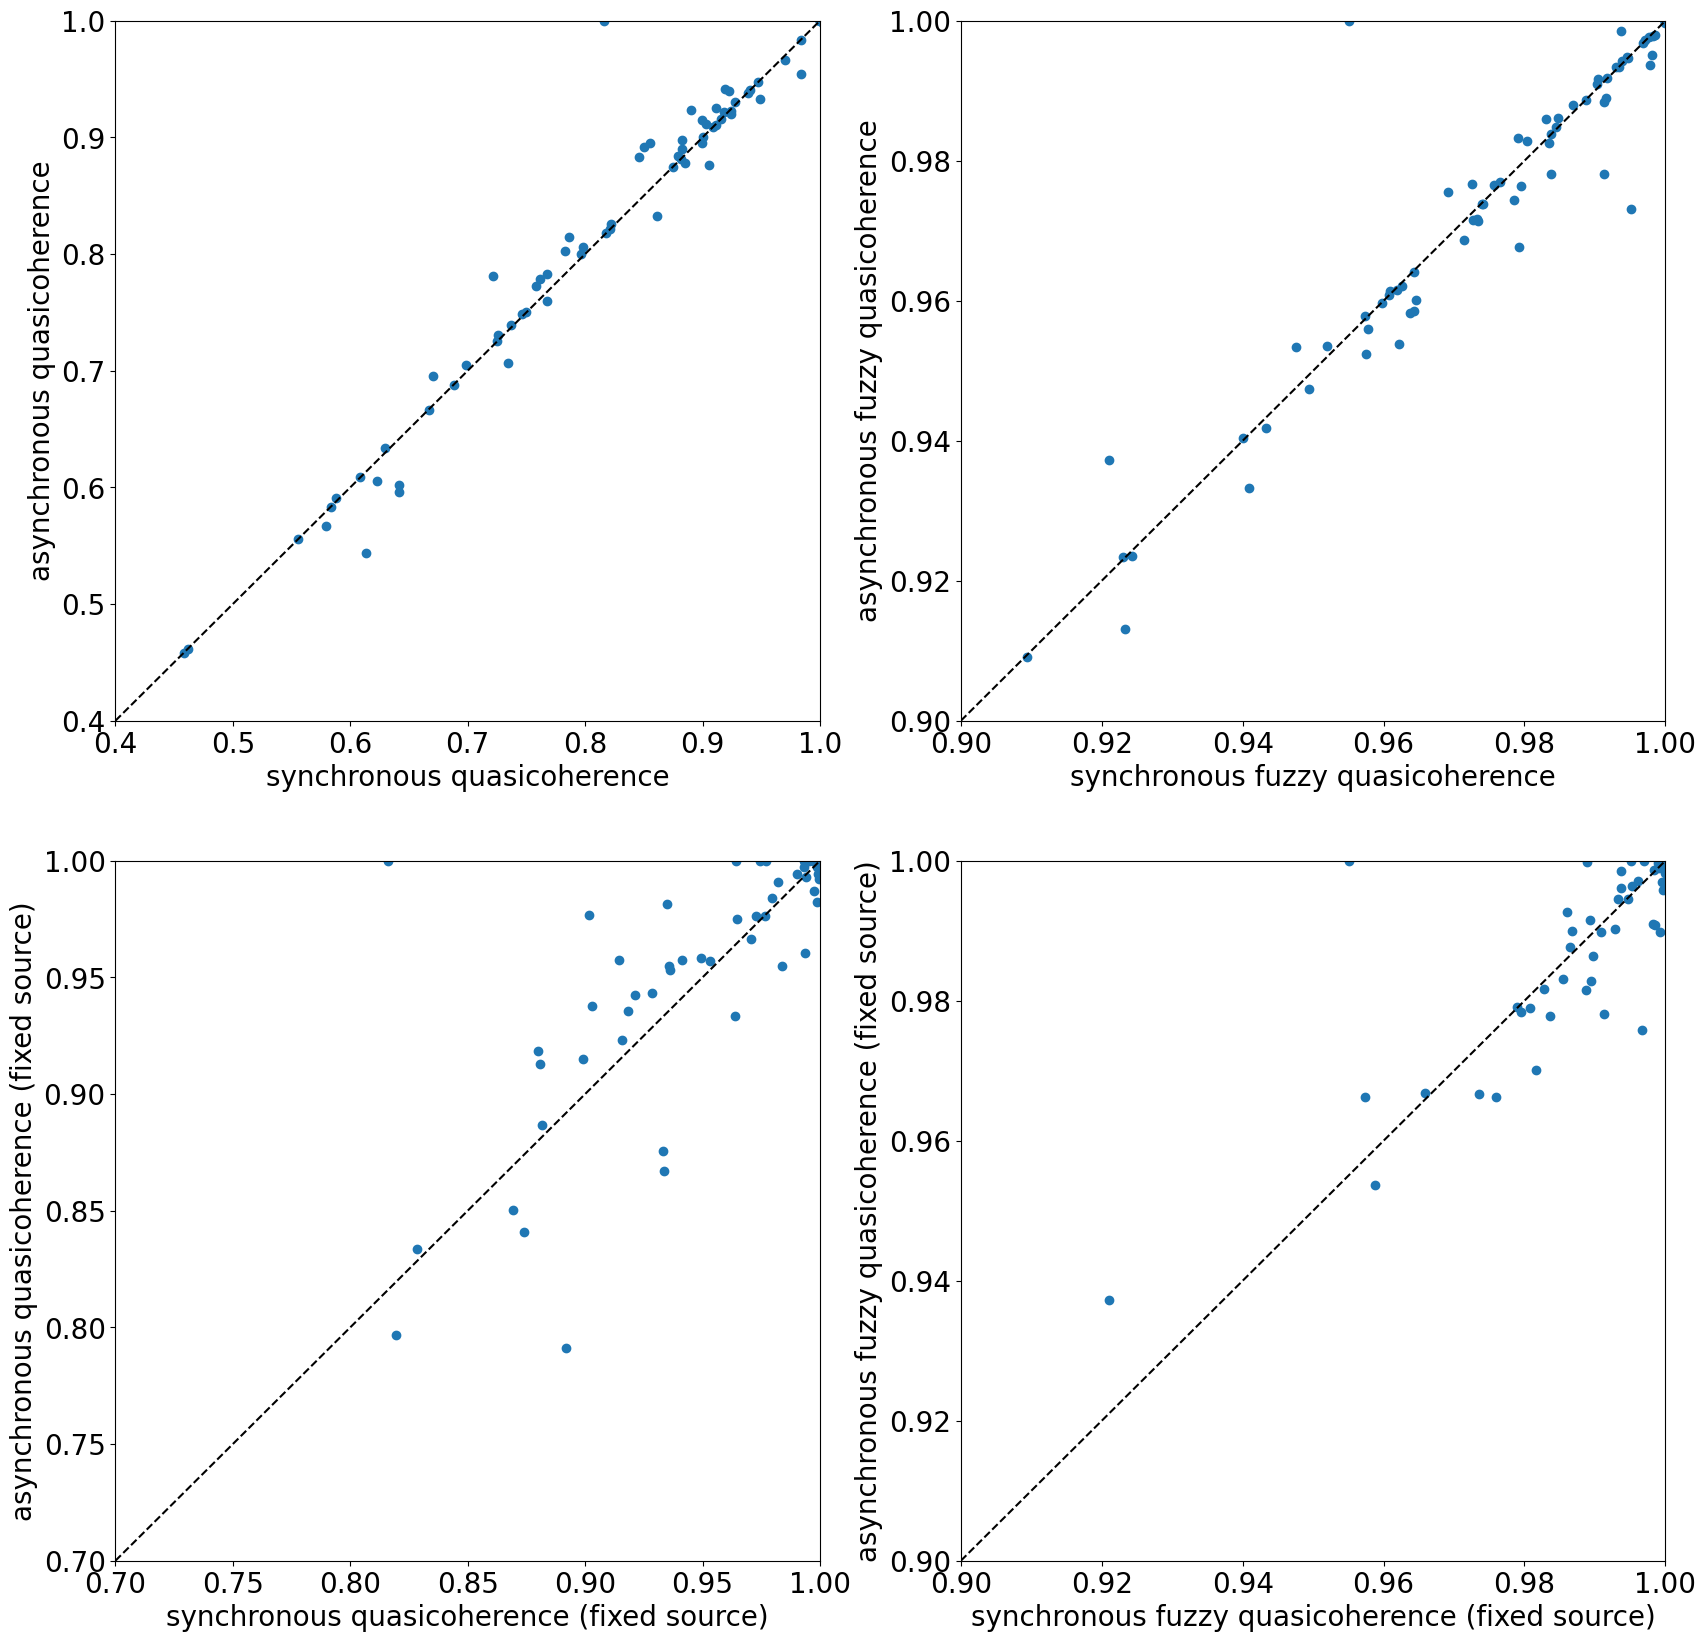

In [3]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

ax[0,0].scatter(QC['SQC'],QC['AQC'])
ax[0,0].set_xlabel('synchronous quasicoherence')
ax[0,0].set_ylabel('asynchronous quasicoherence')
ax[0,0].set_xlim(0.4,1)
ax[0,0].set_ylim(0.4,1)

ax[0,1].scatter(QC['SFQC'],QC['AFQC'])
ax[0,1].set_xlabel('synchronous fuzzy quasicoherence')
ax[0,1].set_ylabel('asynchronous fuzzy quasicoherence')
ax[0,1].set_xlim(0.9,1)
ax[0,1].set_ylim(0.9,1)

ax[1,0].scatter(QC['SQCNS'],QC['AQCNS'])
ax[1,0].set_xlabel('synchronous quasicoherence (fixed source)')
ax[1,0].set_ylabel('asynchronous quasicoherence (fixed source)')
ax[1,0].set_xlim(0.7,1)
ax[1,0].set_ylim(0.7,1)

ax[1,1].scatter(QC['SFQCNS'],QC['AFQCNS'])
ax[1,1].set_xlabel('synchronous fuzzy quasicoherence (fixed source)')
ax[1,1].set_ylabel('asynchronous fuzzy quasicoherence (fixed source)')
ax[1,1].set_xlim(0.9,1)
ax[1,1].set_ylim(0.9,1)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/quasicoherence_comparisons.png')
plt.savefig('./figures/quasicoherence_comparisons.pdf')
plt.show()

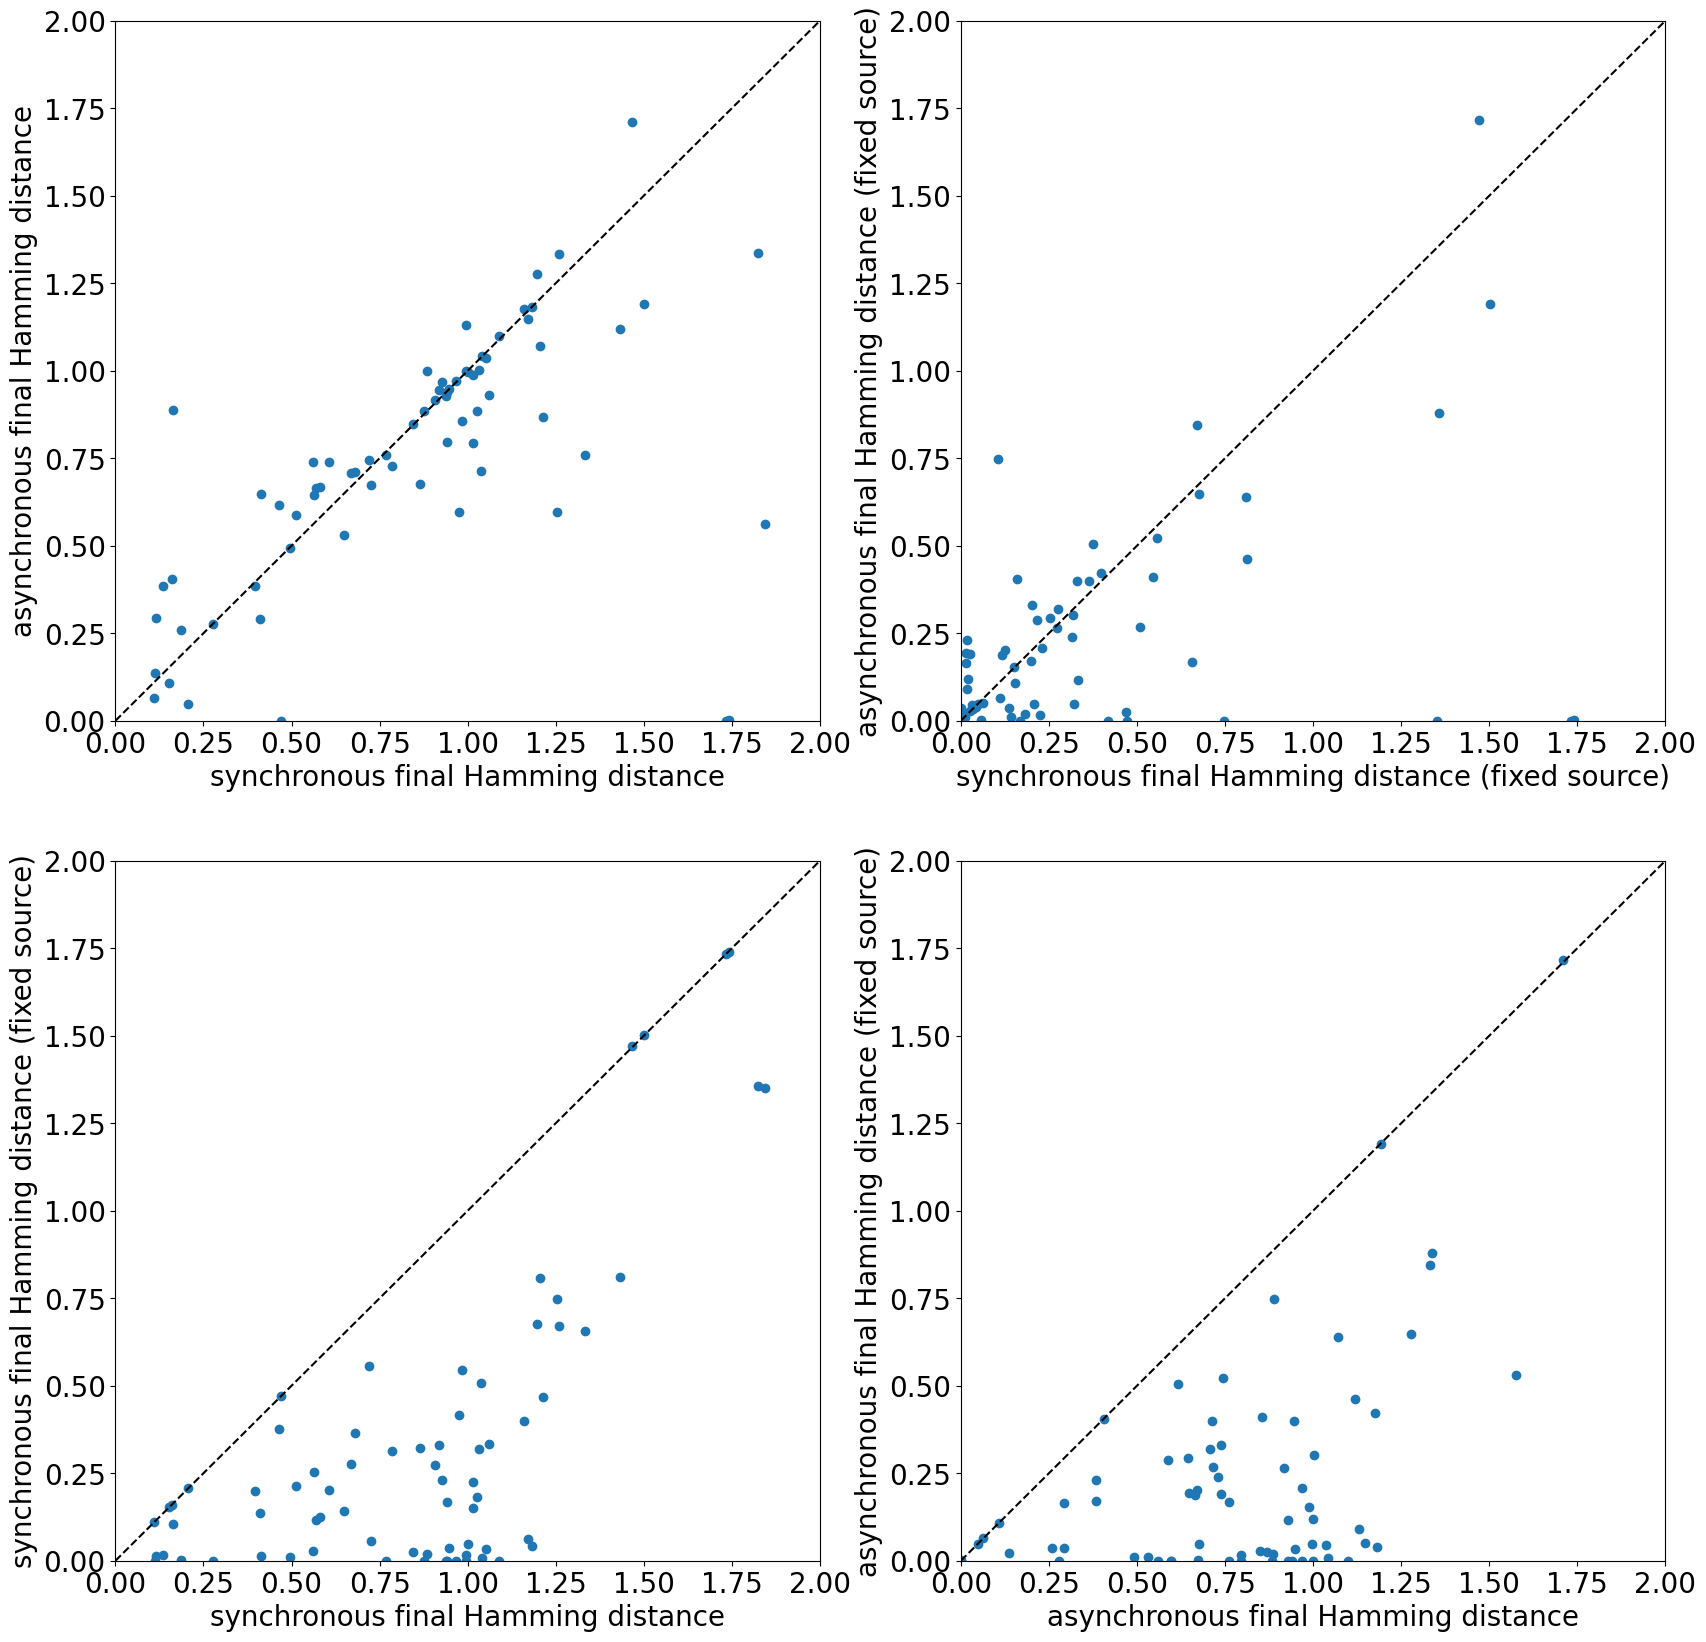

In [4]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

ax[0,0].scatter(QC['SFHD'],QC['AFHD'])
ax[0,0].set_xlabel('synchronous final Hamming distance')
ax[0,0].set_ylabel('asynchronous final Hamming distance')
ax[0,0].set_xlim(0,2)
ax[0,0].set_ylim(0,2)
ax[0,1].scatter(QC['SFHDNS'],QC['AFHDNS'])
ax[0,1].set_xlabel('synchronous final Hamming distance (fixed source)')
ax[0,1].set_ylabel('asynchronous final Hamming distance (fixed source)')
ax[0,1].set_xlim(0,2)
ax[0,1].set_ylim(0,2)

ax[1,0].scatter(QC['SFHD'],QC['SFHDNS'])
ax[1,0].set_xlabel('synchronous final Hamming distance')
ax[1,0].set_ylabel('synchronous final Hamming distance (fixed source)')
ax[1,0].set_xlim(0,2)
ax[1,0].set_ylim(0,2)
ax[1,1].scatter(QC['AFHD'],QC['AFHDNS'])
ax[1,1].set_xlabel('asynchronous final Hamming distance')
ax[1,1].set_ylabel('asynchronous final Hamming distance (fixed source)')
ax[1,1].set_xlim(0,2)
ax[1,1].set_ylim(0,2)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')


plt.savefig('./figures/Hamming_comparison.png')
plt.savefig('./figures/Hamming_comparison.pdf')
plt.show()

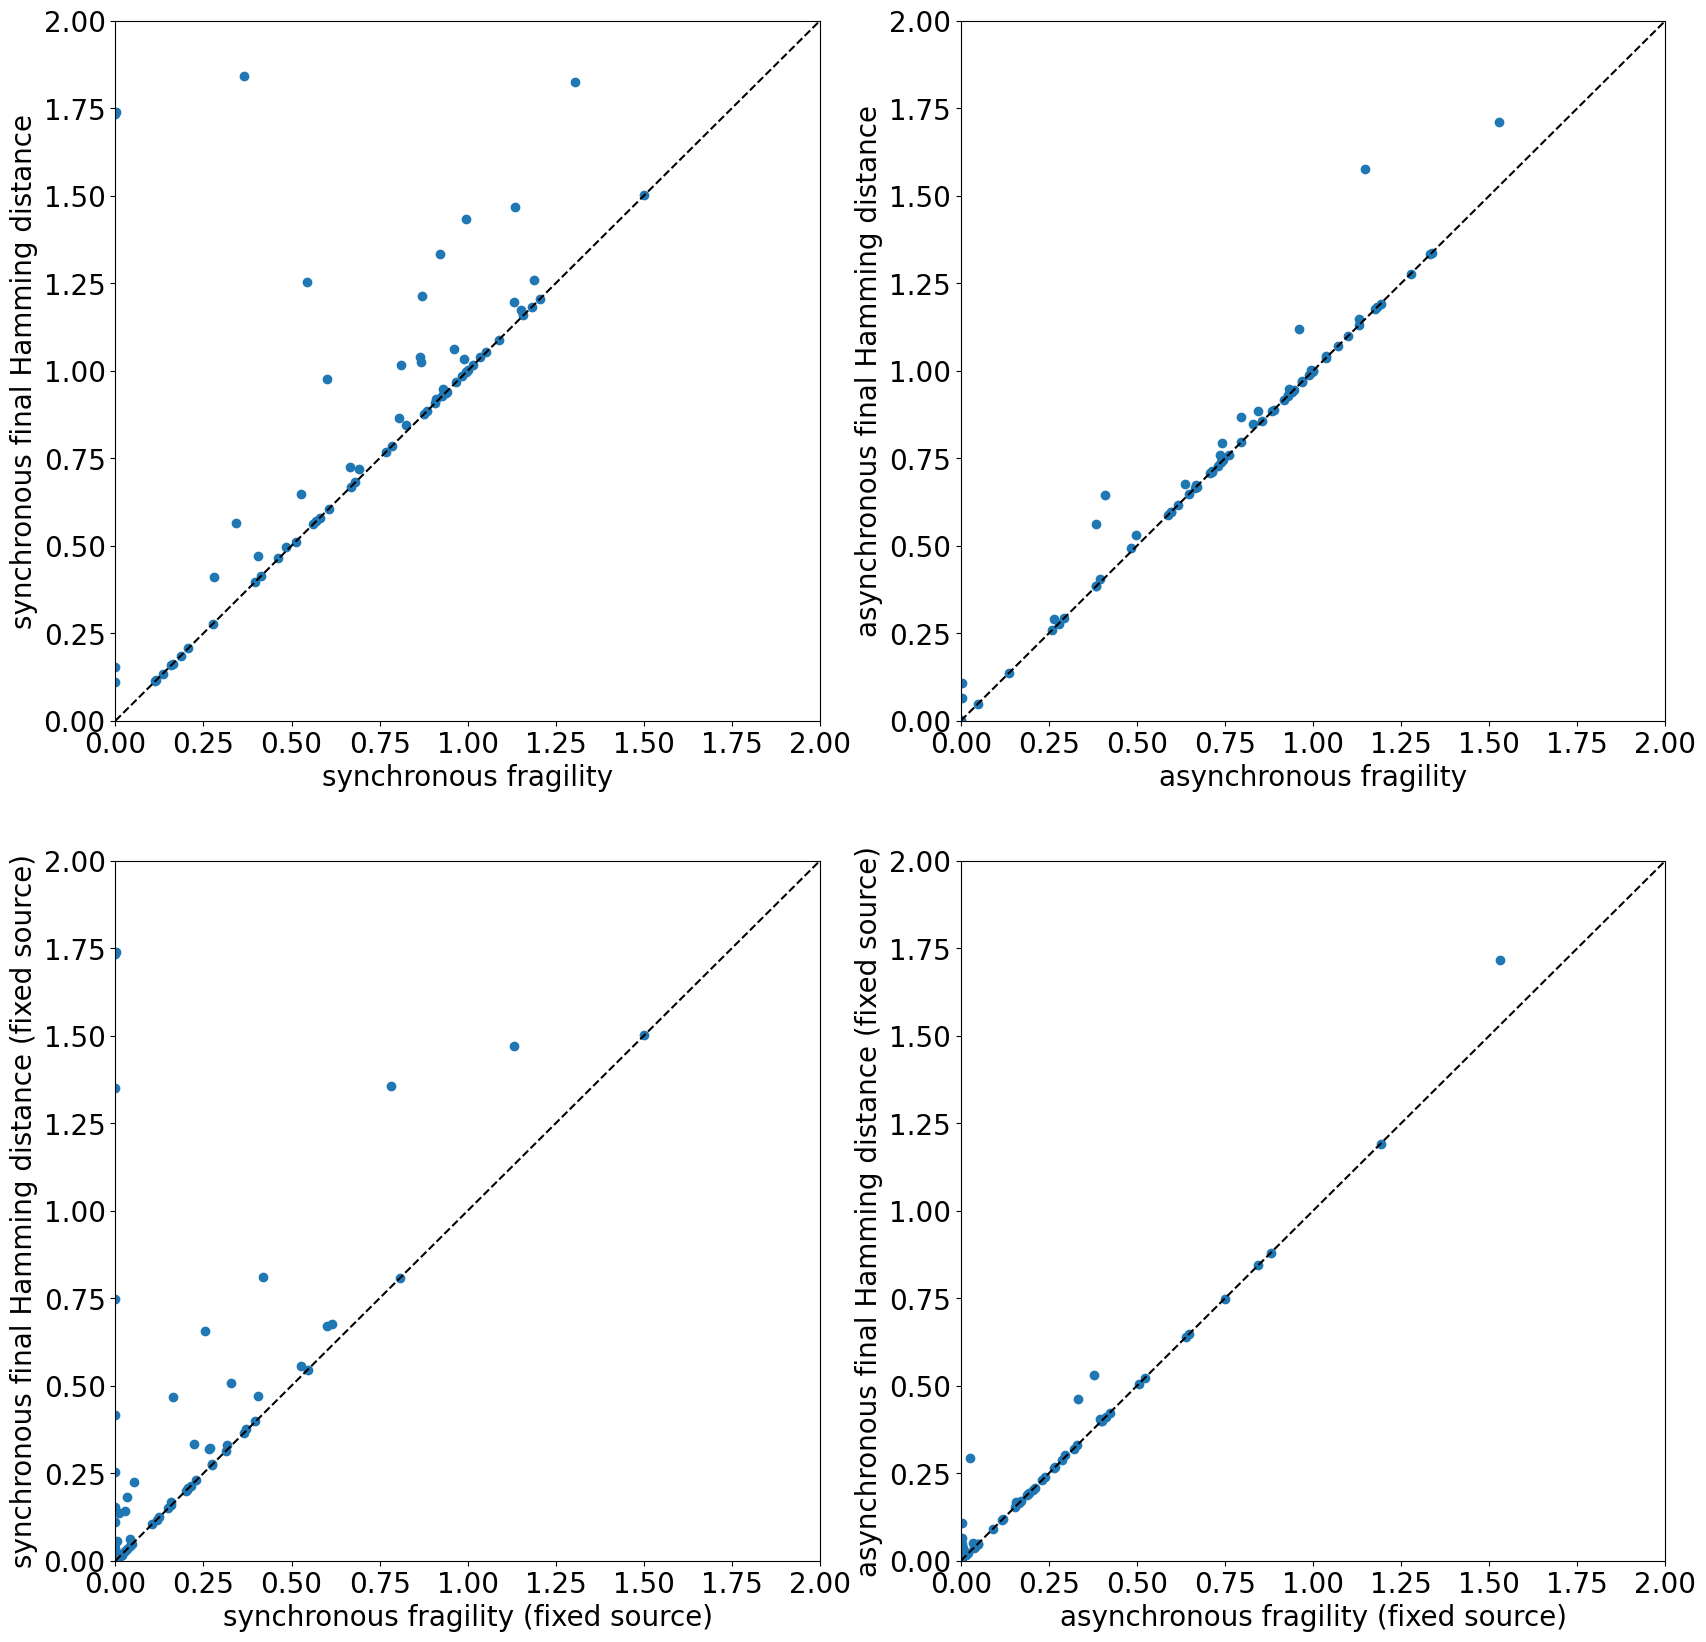

In [5]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

ax[0,0].scatter(QC['SF'],QC['SFHD'])
ax[0,0].set_xlabel('synchronous fragility')
ax[0,0].set_ylabel('synchronous final Hamming distance')
ax[0,0].set_xlim(0,2)
ax[0,0].set_ylim(0,2)
ax[0,1].scatter(QC['AF'],QC['AFHD'])
ax[0,1].set_xlabel('asynchronous fragility')
ax[0,1].set_ylabel('asynchronous final Hamming distance')
ax[0,1].set_xlim(0,2)
ax[0,1].set_ylim(0,2)

ax[1,0].scatter(QC['SFNS'],QC['SFHDNS'])
ax[1,0].set_xlabel('synchronous fragility (fixed source)')
ax[1,0].set_ylabel('synchronous final Hamming distance (fixed source)')
ax[1,0].set_xlim(0,2)
ax[1,0].set_ylim(0,2)
ax[1,1].scatter(QC['AFNS'],QC['AFHDNS'])
ax[1,1].set_xlabel('asynchronous fragility (fixed source)')
ax[1,1].set_ylabel('asynchronous final Hamming distance (fixed source)')
ax[1,1].set_xlim(0,2)
ax[1,1].set_ylim(0,2)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/Hamming-Fragility.png')
plt.savefig('./figures/Hamming-Fragility.pdf')
plt.show()

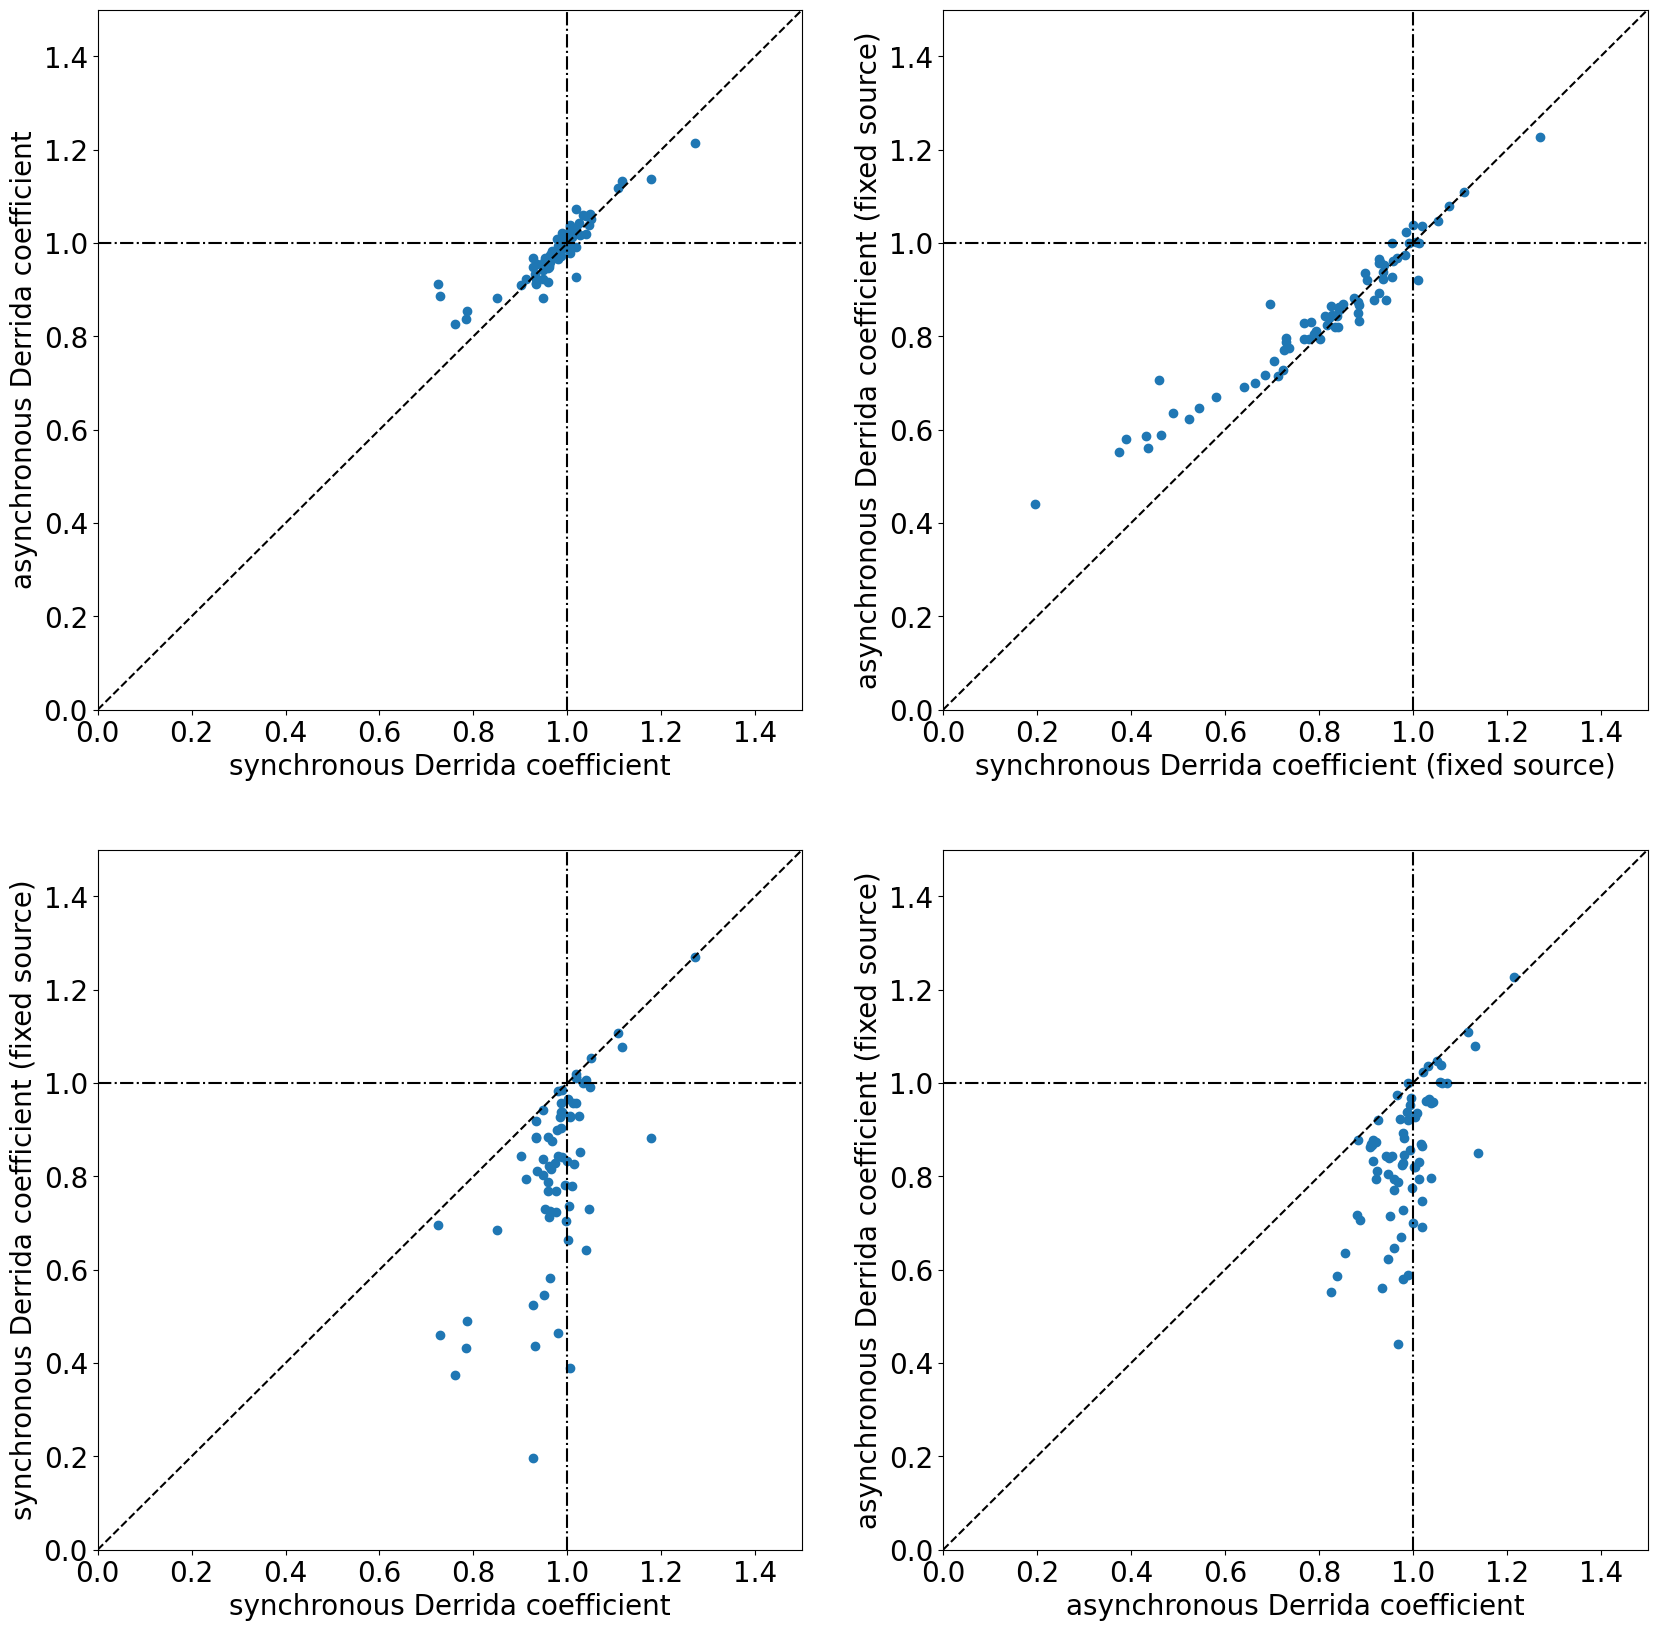

In [6]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

ax[0,0].scatter(QC['SDC'],QC['ADC'])
ax[0,0].set_xlabel('synchronous Derrida coefficient')
ax[0,0].set_ylabel('asynchronous Derrida coefficient')
ax[0,0].set_xlim(0,1.5)
ax[0,0].set_ylim(0,1.5)

ax[0,1].scatter(QC['SDCNS'],QC['ADCNS'])
ax[0,1].set_xlabel('synchronous Derrida coefficient (fixed source)')
ax[0,1].set_ylabel('asynchronous Derrida coefficient (fixed source)')
ax[0,1].set_xlim(0,1.5)
ax[0,1].set_ylim(0,1.5)

ax[1,0].scatter(QC['SDC'],QC['SDCNS'])
ax[1,0].set_xlabel('synchronous Derrida coefficient')
ax[1,0].set_ylabel('synchronous Derrida coefficient (fixed source)')
ax[1,0].set_xlim(0,1.5)
ax[1,0].set_ylim(0,1.5)

ax[1,1].scatter(QC['ADC'],QC['ADCNS'])
ax[1,1].set_xlabel('asynchronous Derrida coefficient')
ax[1,1].set_ylabel('asynchronous Derrida coefficient (fixed source)')
ax[1,1].set_xlim(0,1.5)
ax[1,1].set_ylim(0,1.5)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')
    sub_ax.hlines(1,0,1.5,linestyle='-.',color='k')
    sub_ax.vlines(1,0,1.5,linestyle='-.',color='k')

plt.savefig('./figures/Derrida_comparison.png')
plt.savefig('./figures/Derrida_comparison.pdf')
plt.show()

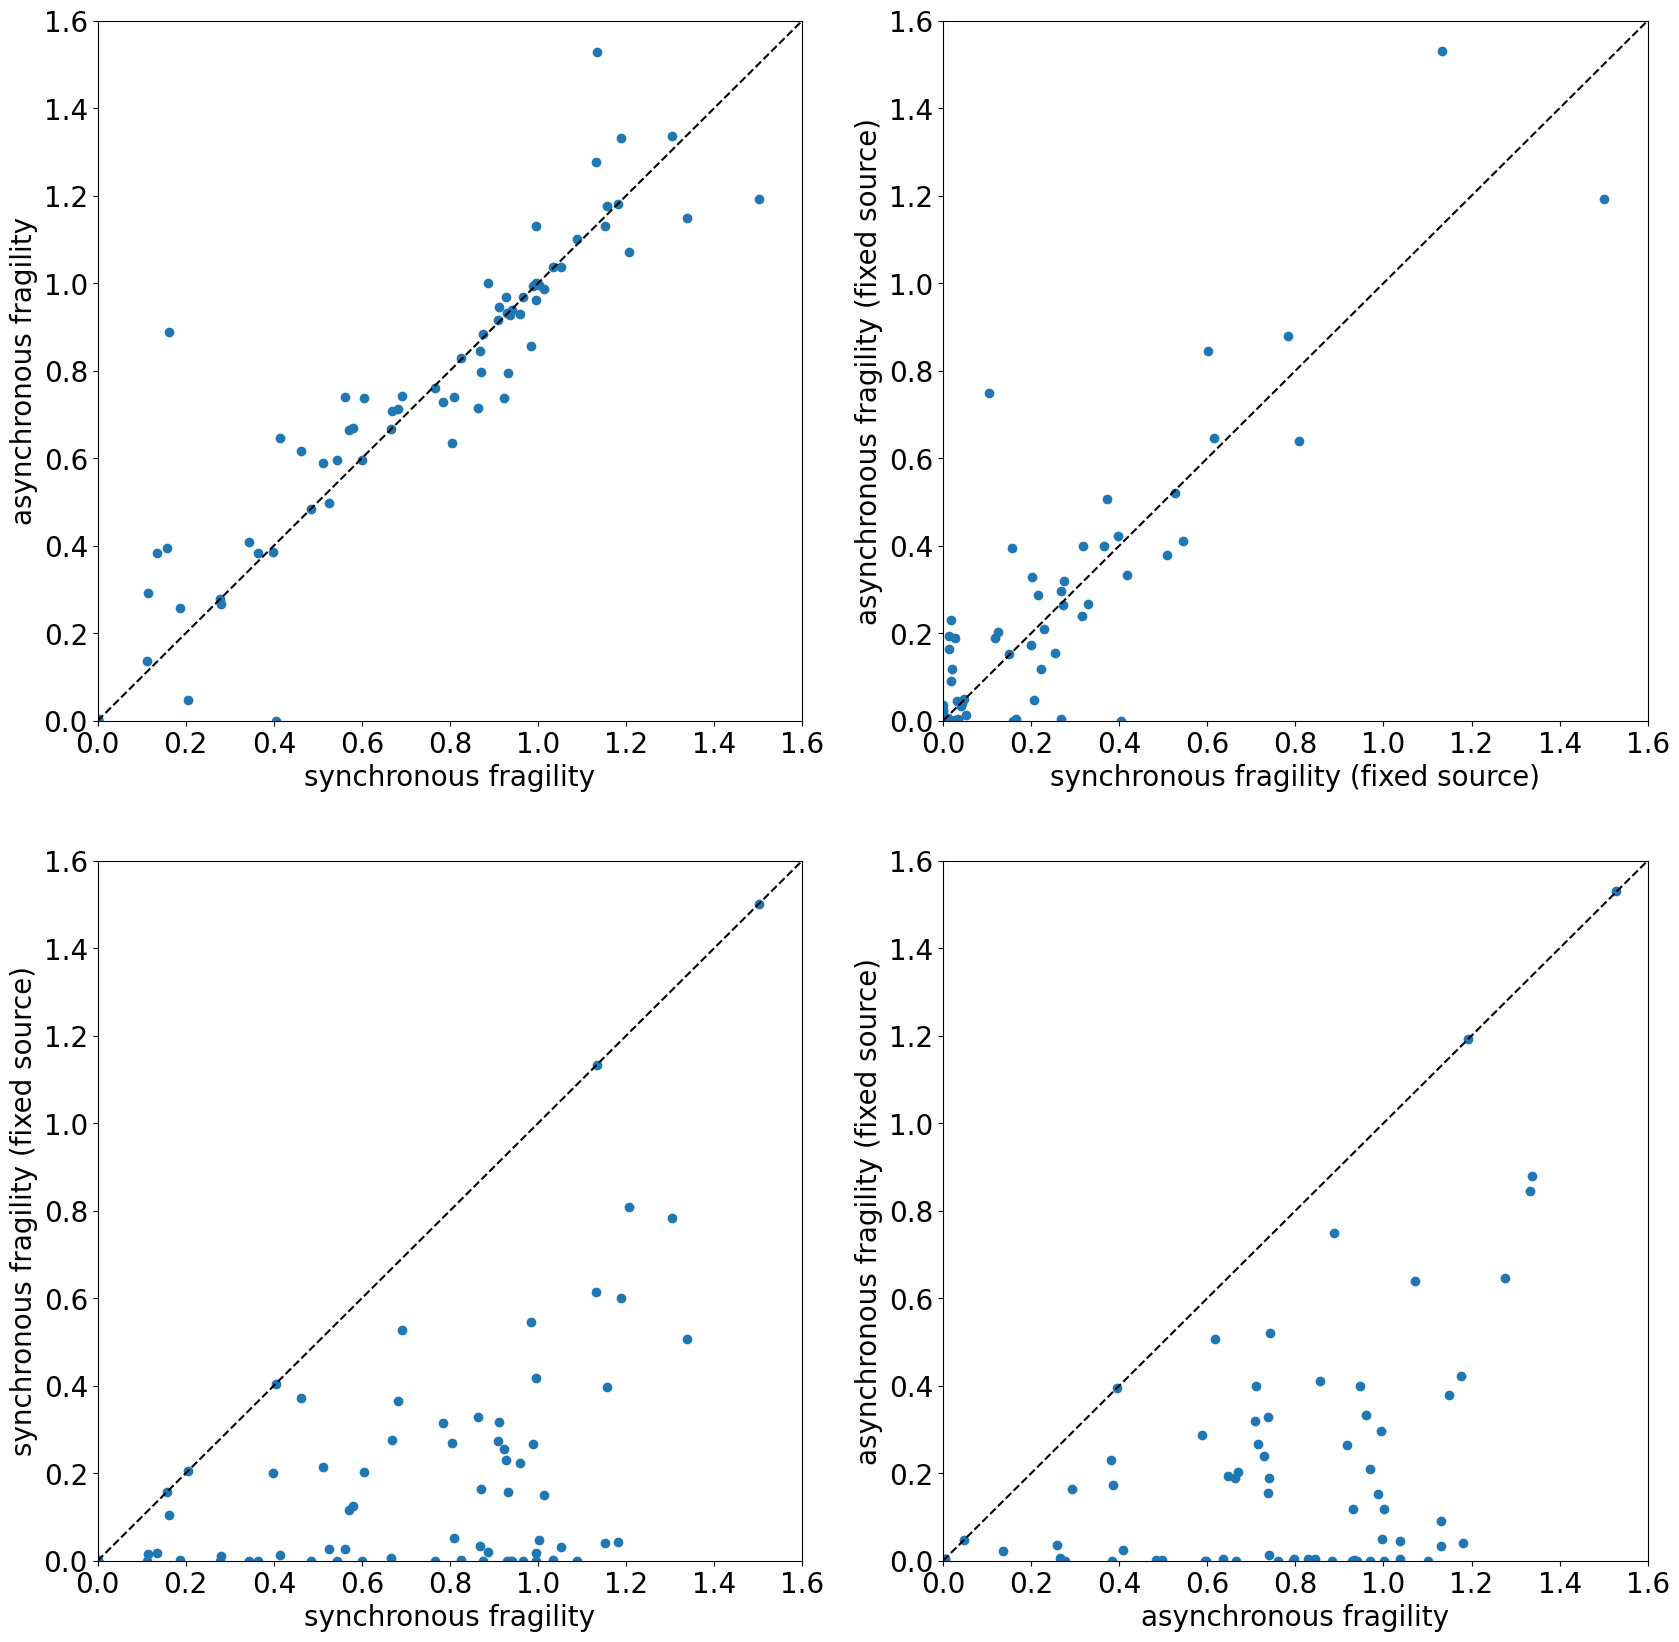

In [7]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

ax[0,0].scatter(QC['SF'],QC['AF'])
ax[0,0].set_xlabel('synchronous fragility')
ax[0,0].set_ylabel('asynchronous fragility')
ax[0,0].set_xlim(0,1.6)
ax[0,0].set_ylim(0,1.6)

ax[0,1].scatter(QC['SFNS'],QC['AFNS'])
ax[0,1].set_xlabel('synchronous fragility (fixed source)')
ax[0,1].set_ylabel('asynchronous fragility (fixed source)')
ax[0,1].set_xlim(0,1.6)
ax[0,1].set_ylim(0,1.6)

ax[1,0].scatter(QC['SF'],QC['SFNS'])
ax[1,0].set_xlabel('synchronous fragility')
ax[1,0].set_ylabel('synchronous fragility (fixed source)')
ax[1,0].set_xlim(0,1.6)
ax[1,0].set_ylim(0,1.6)

ax[1,1].scatter(QC['AF'],QC['AFNS'])
ax[1,1].set_xlabel('asynchronous fragility')
ax[1,1].set_ylabel('asynchronous fragility (fixed source)')
ax[1,1].set_xlim(0,1.6)
ax[1,1].set_ylim(0,1.6)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/fragility_comparison.png')
plt.savefig('./figures/fragility_comparison.pdf')
plt.show()

/tmp/ipykernel_621818/2863579064.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


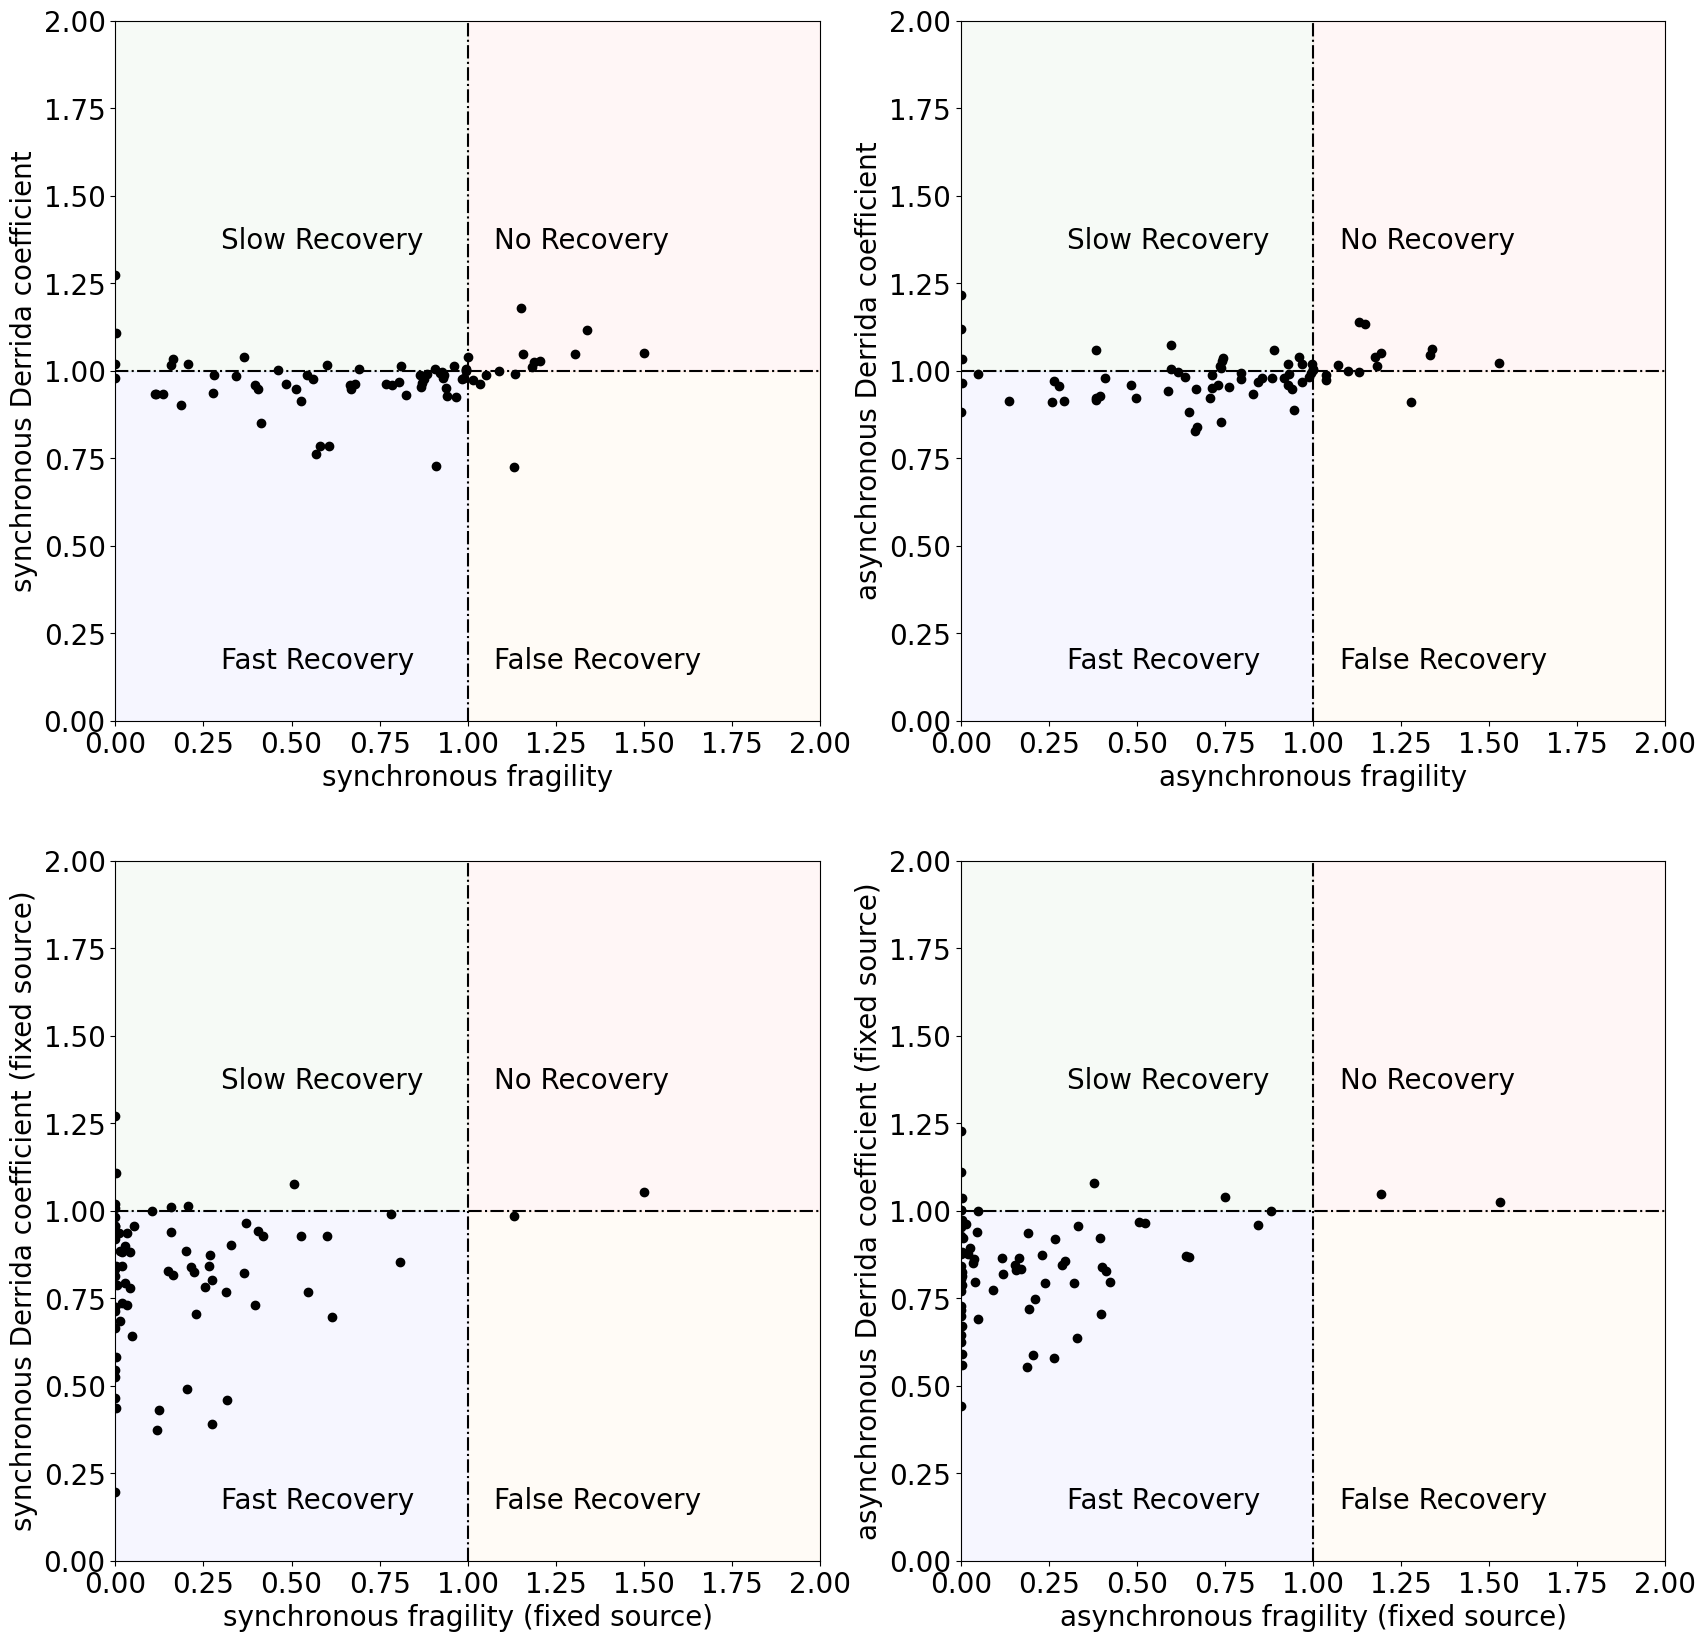

In [8]:
region_alpha = 0.035
cmap = plt.cm.get_cmap('coolwarm')
maxval = 2.0
cnorm=CenteredNorm(vcenter=0,halfrange=0.5)
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for sub_ax in ax.flatten():
    regions = [
        Rectangle((0,0),1,1,color='blue',alpha=region_alpha),
        Rectangle((1,1),maxval-1,maxval-1,color='red',alpha=region_alpha),
        Rectangle((0,1),1,maxval-1,color='green',alpha=region_alpha),
        Rectangle((1,0),maxval-1,1,color='orange',alpha=region_alpha),
        ]
    
    #sub_ax.axline((1,1),slope=1,linestyle='--',color='k')
    sub_ax.hlines(1,0,maxval,linestyle='-.',color='k')
    sub_ax.vlines(1,0,maxval,linestyle='-.',color='k')
    [sub_ax.add_patch(r) for r in regions]
    sub_ax.annotate('Slow Recovery',xy=(0.3,1.35))
    sub_ax.annotate('Fast Recovery',xy=(0.3,0.15))
    sub_ax.annotate('False Recovery',xy=(1.075,0.15))
    sub_ax.annotate('No Recovery',xy=(1.075,1.35))

ax[0,0].scatter(QC['SF'],QC['SDC'],
                c='k')#c=QC['SF']-QC['SDC'],cmap=cmap, norm=cnorm)
ax[0,0].set_xlabel('synchronous fragility')
ax[0,0].set_ylabel('synchronous Derrida coefficient')
ax[0,0].set_xlim(0,maxval)
ax[0,0].set_ylim(0,maxval)

ax[0,1].scatter(QC['AF'],QC['ADC'],
                c='k')#c=QC['AF']-QC['ADC'],cmap=cmap, norm=cnorm)
ax[0,1].set_xlabel('asynchronous fragility')
ax[0,1].set_ylabel('asynchronous Derrida coefficient')
ax[0,1].set_xlim(0,maxval)
ax[0,1].set_ylim(0,maxval)

ax[1,0].scatter(QC['SFNS'],QC['SDCNS'],
                c='k')#c=QC['SFNS']-QC['SDCNS'],cmap=cmap, norm=cnorm)
ax[1,0].set_xlabel('synchronous fragility (fixed source)')
ax[1,0].set_ylabel('synchronous Derrida coefficient (fixed source)')
ax[1,0].set_xlim(0,maxval)
ax[1,0].set_ylim(0,maxval)

ax[1,1].scatter(QC['AFNS'],QC['ADCNS'],
                c='k')#c=QC['AFNS']-QC['ADCNS'],cmap=cmap, norm=cnorm)
ax[1,1].set_xlabel('asynchronous fragility (fixed source)')
ax[1,1].set_ylabel('asynchronous Derrida coefficient (fixed source)')
ax[1,1].set_xlim(0,maxval)
ax[1,1].set_ylim(0,maxval)



plt.savefig('./figures/Derrida-Fragility.png')
plt.savefig('./figures/Derrida-Fragility.pdf')
plt.show()

/tmp/ipykernel_621818/1767377371.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


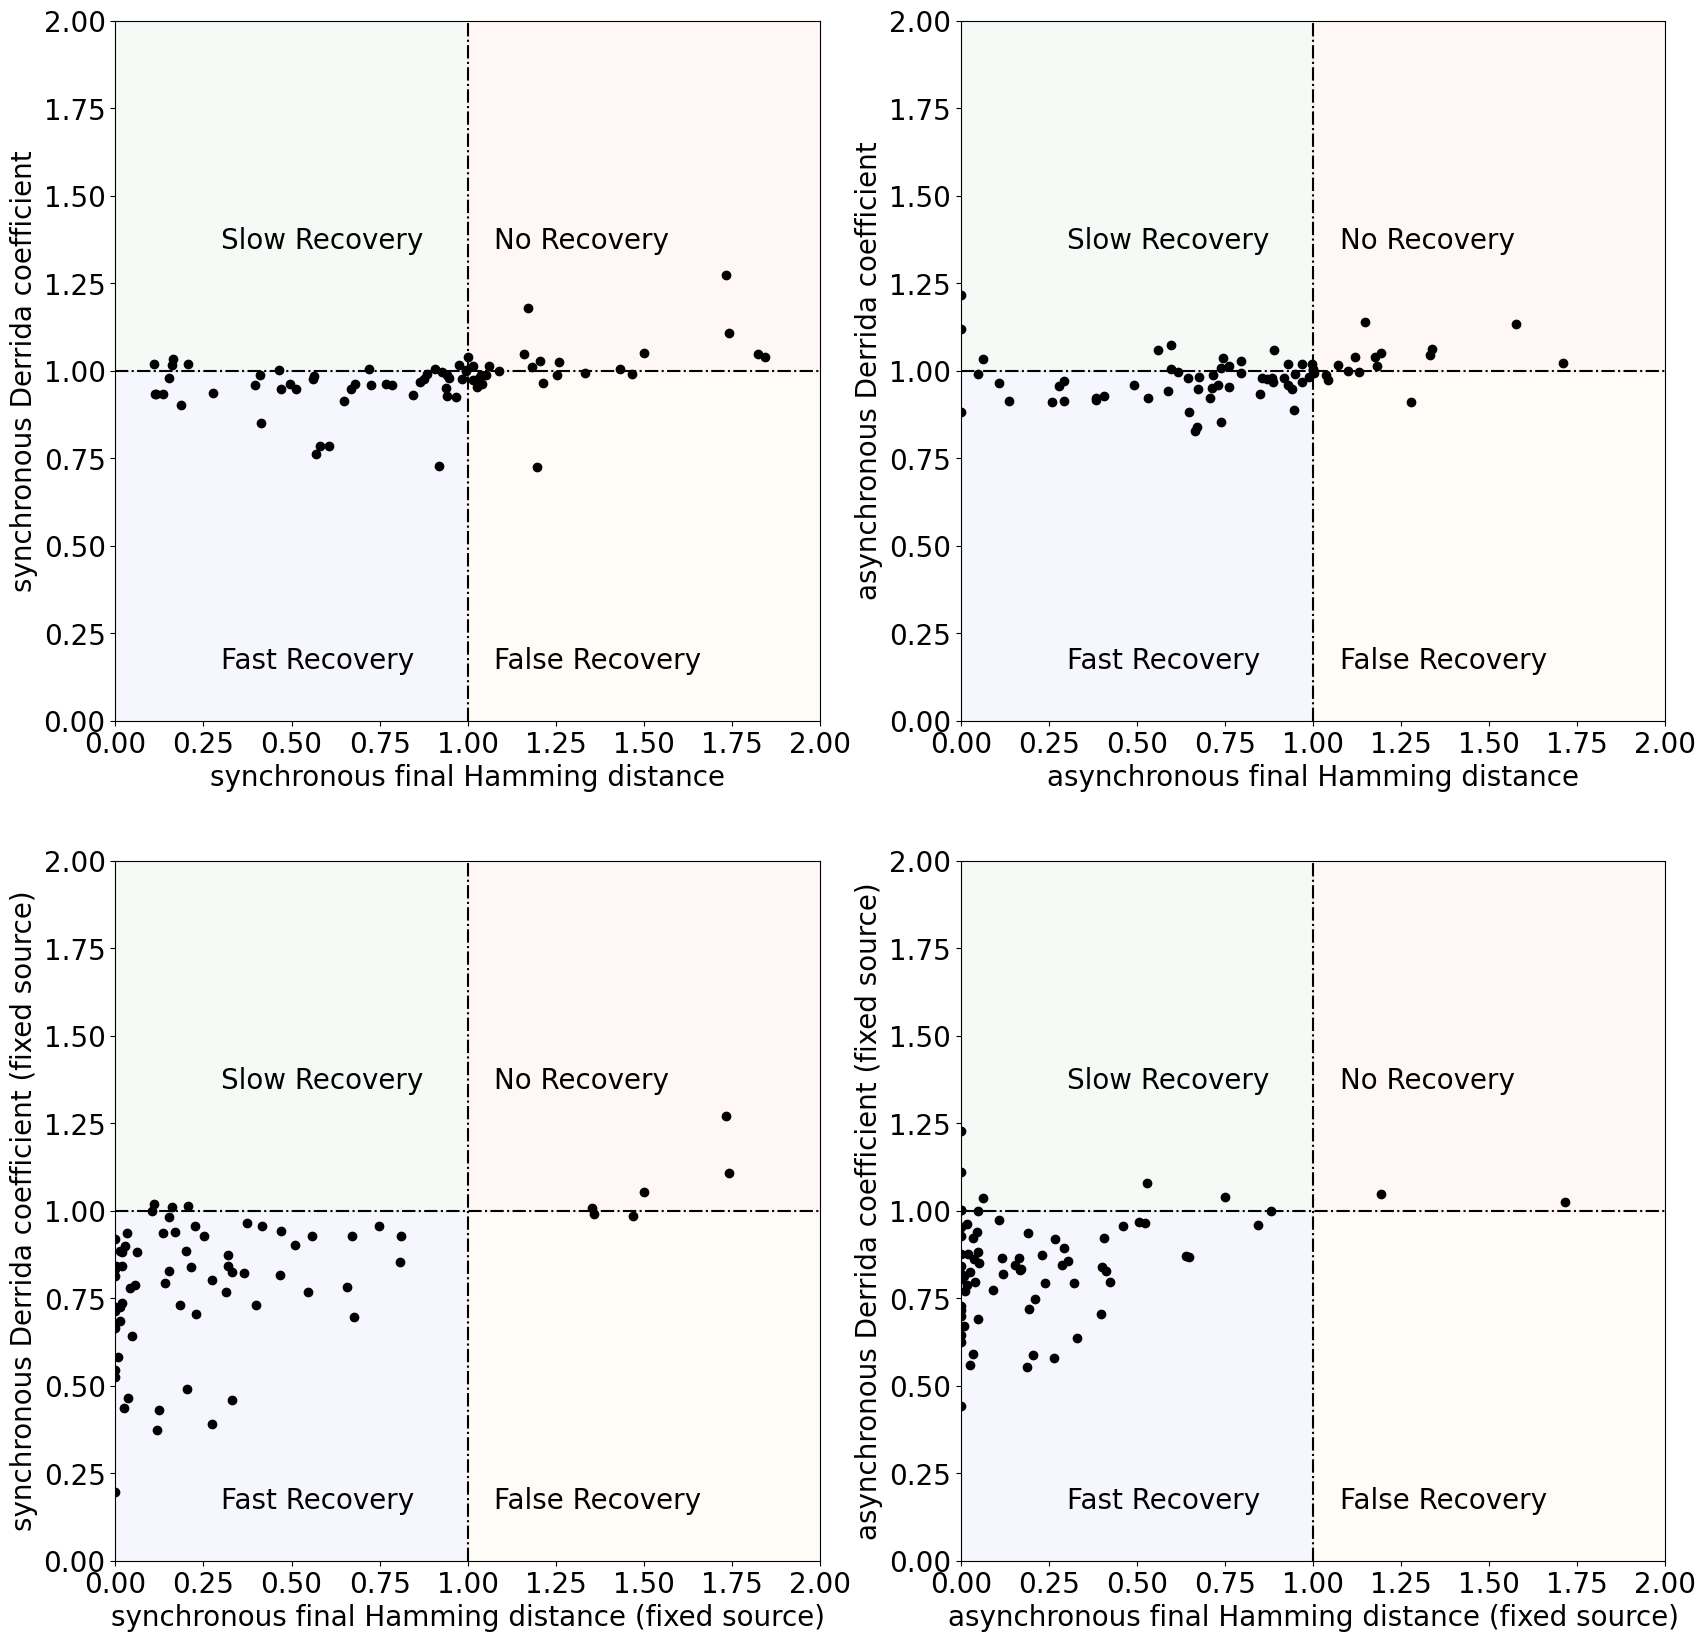

In [9]:
region_alpha = 0.035
cmap = plt.cm.get_cmap('coolwarm')
maxval = 2.0
cnorm=CenteredNorm(vcenter=0,halfrange=0.5)
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for sub_ax in ax.flatten():
    regions = [
        Rectangle((0,0),1,1,color='blue',alpha=region_alpha),
        Rectangle((1,1),maxval-1,maxval-1,color='red',alpha=region_alpha),
        Rectangle((0,1),1,maxval-1,color='green',alpha=region_alpha),
        Rectangle((1,0),maxval-1,1,color='orange',alpha=region_alpha),
        ]
    
    #sub_ax.axline((1,1),slope=1,linestyle='--',color='k')
    sub_ax.hlines(1,0,maxval,linestyle='-.',color='k')
    sub_ax.vlines(1,0,maxval,linestyle='-.',color='k')
    [sub_ax.add_patch(r) for r in regions]
    sub_ax.annotate('Slow Recovery',xy=(0.3,1.35))
    sub_ax.annotate('Fast Recovery',xy=(0.3,0.15))
    sub_ax.annotate('False Recovery',xy=(1.075,0.15))
    sub_ax.annotate('No Recovery',xy=(1.075,1.35))

ax[0,0].scatter(QC['SFHD'],QC['SDC'],
                c='k')#c=QC['SF']-QC['SDC'],cmap=cmap, norm=cnorm)
ax[0,0].set_xlabel('synchronous final Hamming distance')
ax[0,0].set_ylabel('synchronous Derrida coefficient')
ax[0,0].set_xlim(0,maxval)
ax[0,0].set_ylim(0,maxval)

ax[0,1].scatter(QC['AFHD'],QC['ADC'],
                c='k')#c=QC['AF']-QC['ADC'],cmap=cmap, norm=cnorm)
ax[0,1].set_xlabel('asynchronous final Hamming distance')
ax[0,1].set_ylabel('asynchronous Derrida coefficient')
ax[0,1].set_xlim(0,maxval)
ax[0,1].set_ylim(0,maxval)

ax[1,0].scatter(QC['SFHDNS'],QC['SDCNS'],
                c='k')#c=QC['SFNS']-QC['SDCNS'],cmap=cmap, norm=cnorm)
ax[1,0].set_xlabel('synchronous final Hamming distance (fixed source)')
ax[1,0].set_ylabel('synchronous Derrida coefficient (fixed source)')
ax[1,0].set_xlim(0,maxval)
ax[1,0].set_ylim(0,maxval)

ax[1,1].scatter(QC['AFHDNS'],QC['ADCNS'],
                c='k')#c=QC['AFNS']-QC['ADCNS'],cmap=cmap, norm=cnorm)
ax[1,1].set_xlabel('asynchronous final Hamming distance (fixed source)')
ax[1,1].set_ylabel('asynchronous Derrida coefficient (fixed source)')
ax[1,1].set_xlim(0,maxval)
ax[1,1].set_ylim(0,maxval)



plt.savefig('./figures/Derrida-Hamming.png')
plt.savefig('./figures/Derrida-Hamming.pdf')
plt.show()